In [4]:
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error, make_scorer, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# Load dataset
df = pd.read_csv("cleaned_tonometry_dataset.csv")

# Features and target
X = df.drop(columns=["Age", "patient_id"], errors='ignore')
y = df["Age"]

# Preprocessing pipeline
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]), X.columns)
], remainder="drop")

# Linear Regression model
lr_model = LinearRegression()

# Full pipeline
pipe_inner = Pipeline([
    ("prep", preprocess),
    ("reg", lr_model)
])

# GridSearch (no hyperparameters for LinearRegression)
grid = GridSearchCV(
    estimator=pipe_inner,
    param_grid={},
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring="neg_mean_absolute_error",
    refit=True,
    n_jobs=-1
)

# Nested CV for performance estimation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(
    estimator=grid,
    X=X, y=y,
    cv=outer_cv,
    scoring={"MAE": make_scorer(mean_absolute_error)},
    return_estimator=True,
    n_jobs=-1
)

# Best model from outer CV folds
best_idx = np.argmin(cv_results["test_MAE"])
best_model = cv_results["estimator"][best_idx].best_estimator_

# Predict and evaluate on entire dataset
X_proc = best_model.named_steps["prep"].transform(X)
y_pred = best_model.named_steps["reg"].predict(X_proc)

final_mae = mean_absolute_error(y, y_pred)
final_r2 = r2_score(y, y_pred)

print(f"Final MAE: {final_mae:.2f}")
print(f"Final R² Score: {final_r2:.2f}")

# Save model
joblib.dump(best_model, "final_tonometry_model_lr.pkl")
print("✓ Saved model → final_tonometry_model_lr.pkl")


Final MAE: 9.25
Final R² Score: 0.23
✓ Saved model → final_tonometry_model_lr.pkl


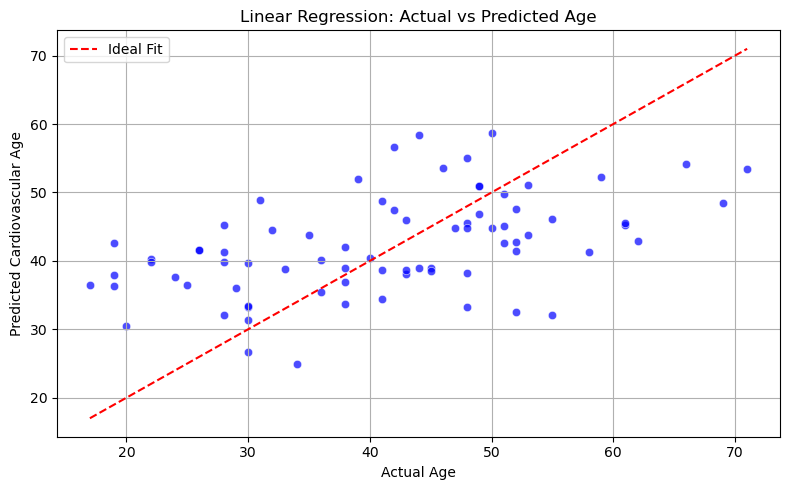

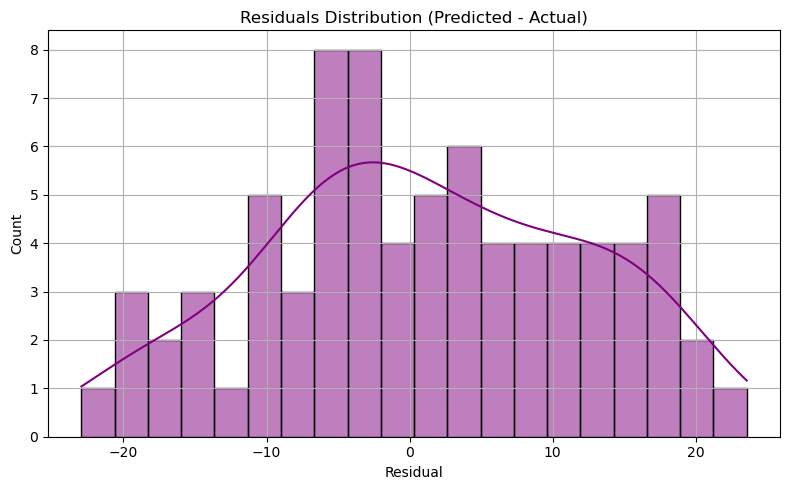

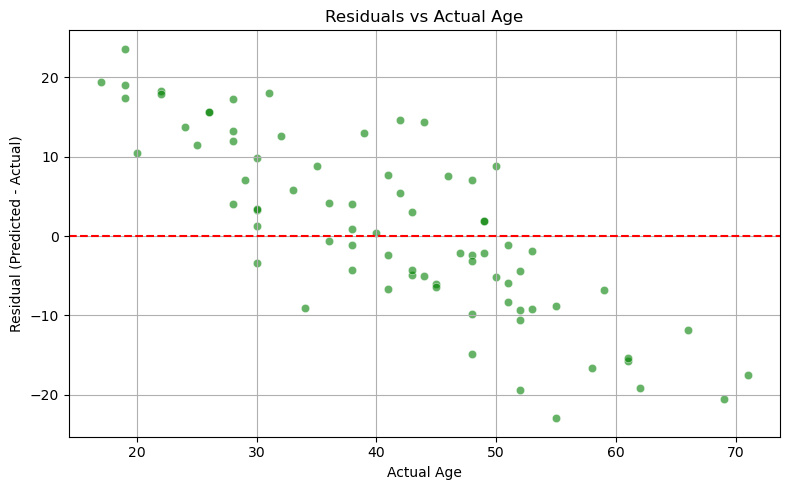

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score

# Actual vs Predicted Scatter Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y, y=y_pred, alpha=0.7, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal Fit')
plt.xlabel("Actual Age")
plt.ylabel("Predicted Cardiovascular Age")
plt.title("Linear Regression: Actual vs Predicted Age")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual Plot (Predicted - Actual)
residuals = y_pred - y
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=20, color='purple')
plt.title("Residuals Distribution (Predicted - Actual)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Residuals vs. Actual Age
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y, y=residuals, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Age")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residuals vs Actual Age")
plt.grid(True)
plt.tight_layout()
plt.show()
